In [8]:
import pandas as pd
import numpy as np
data = pd.read_csv("clean_weather.csv",index_col = 0)
data = data.ffill()
data

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0
...,...,...,...,...
2022-11-22,62.0,35.0,0.0,67.0
2022-11-23,67.0,38.0,0.0,66.0
2022-11-24,66.0,41.0,0.0,70.0
2022-11-25,70.0,39.0,0.0,62.0


In [10]:
data["tmax"].head(10)

1970-01-01    60.0
1970-01-02    52.0
1970-01-03    52.0
1970-01-04    53.0
1970-01-05    52.0
1970-01-06    50.0
1970-01-07    52.0
1970-01-08    56.0
1970-01-09    54.0
1970-01-10    57.0
Name: tmax, dtype: float64

In [11]:
data["tmax"].head(10).to_numpy()[np.newaxis]

array([[60., 52., 52., 53., 52., 50., 52., 56., 54., 57.]])

In [12]:
data["tmax"].head(1).to_numpy()[np.newaxis]

array([[60.]])

In [14]:
np.random.seed(0)
# Set a random seed so the random numbers are the same every time
i_weight = np.random.rand(1,2)
h_weight = np.random.rand(2,2)
o_weight = np.random.rand(2,1)

temps = data["tmax"].tail(3).to_numpy()
temps

array([66., 70., 62.])

In [17]:
x0 = temps[0].reshape(1,1)
x1 = temps[1].reshape(1,1)
x2 = temps[2].reshape(1,1)

In [18]:
x0


array([[66.]])

In [19]:
xi_0 = x0 @ i_weight
xi_0

array([[36.22169126, 47.20249818]])

In [20]:
xh_0 = np.maximum(0, xi_0) # relu activation funcitno
xh_0

array([[36.22169126, 47.20249818]])

In [22]:
# There is no previous time step, so there is no hidden state
# apply relu over the input to get the hidden state for time step 0 xh_0
xo_0 = xh_0 @ o_weight
xo_0

array([[57.94406231]])

In [23]:
xi_1 = x1 @ i_weight

xh = xh_0 @ h_weight

xh_1 = np.maximum(0, xh + xi_1)

xo_1 = xh_1 @ o_weight

xo_1

array([[124.54916092]])

In [24]:
# We feed the input in the same way as the previous time step
xi_2 = x2 @ i_weight

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_1 by the hidden weights
xh = xh_1 @ h_weight

# We add the previous hidden state (times h_weight) to the input at time step 2
xh_2 = np.maximum(0, xh + xi_2)

# We again find the output by multiplying xh_1 by the output weight
xo_2 = xh_2 @ o_weight

xo_2

array([[190.94853131]])

In [25]:
#hyperbolic tan

import matplotlib.pyplot as plt
temps = np.arange(-10, 10, .1)

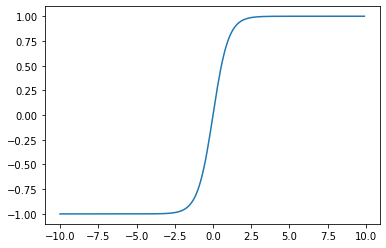

In [26]:
plt.plot(temps, np.tanh(temps))

In [27]:
from sympy import diff, symbols, exp

x = symbols("x")
sympy_tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
diff(sympy_tanh, x)

(-exp(x) + exp(-x))*(exp(x) - exp(-x))/(exp(x) + exp(-x))**2 + 1

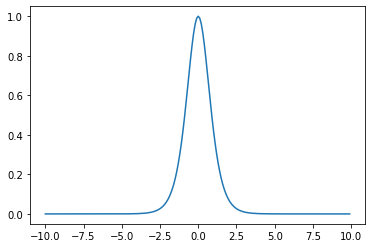

In [28]:
plt.plot(temps, 1 - np.tanh(temps) ** 2)

In [29]:
np.random.seed(0)

# Define our weights and biases
# Scale them down so values get through the tanh nonlinearity
i_weight = np.random.rand(1,5) / 5 - .1
h_weight = np.random.rand(5,5) / 5 - .1
h_bias = np.random.rand(1,5) / 5 - .1

# Tanh pushes values to between -1 and 1, so scale up the output weights
o_weight = np.random.rand(5,1) * 50
o_bias = np.random.rand(1,1)

In [30]:
# An array to store the output predictions
outputs = np.zeros(3)
# An array to store hidden states for use in backpropagation
hiddens = np.zeros((3, 5))

# This will store the previous hidden state, since we'll need it to calculate the current hidden step
prev_hidden = None
sequence = data["tmax"].tail(3).to_numpy()

for i in range(3):
    # Get the input sequence at the given position
    x = sequence[i].reshape(1,1)

    # Multiply input by input weight
    xi = x @ i_weight
    if prev_hidden is not None:
        # Add previous hidden to input
        xh = xi + prev_hidden @ h_weight + h_bias
    else:
        xh = xi

    # Apply our activation function
    xh = np.tanh(xh)
    prev_hidden = xh
    hiddens[i,] = xh

    # Multiply by the output weight
    xo = xh @ o_weight + o_bias
    outputs[i] = xo

In [31]:
outputs

array([74.31470595, 80.66149404, 77.67852446])

In [32]:
hiddens

array([[ 0.56784618,  0.99320288,  0.87557333,  0.53166114, -0.76483255],
       [ 0.58366756,  0.99568651,  0.90034879,  0.69338529, -0.84149203],
       [ 0.5383306 ,  0.99164251,  0.86287584,  0.66091071, -0.80543591]])

In [33]:
def mse(actual, predicted):
    return np.mean((actual-predicted)**2)

def mse_grad(actual, predicted):
    return (predicted - actual)
 

In [34]:
# Actual next day temperatures
actuals = np.array([70, 62, 65])

loss_grad = mse_grad(actuals, outputs)
loss_grad

array([ 4.31470595, 18.66149404, 12.67852446])

In [35]:
o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5 

In [36]:
# Get the loss wrt the output at the current time step
l2_grad = loss_grad[2].reshape(1,1)

# Add to the output weight gradient
# Multiply the output of the hidden step (hiddens[2]) transposed by the l2 grad
# np.newaxis creates a new size 1 axis, effectively transposing the hiddens
o_weight_grad += hiddens[2][:,np.newaxis] @ l2_grad
# Add to the bias gradient.  Similar to a dense neural network, this is just the mean of the l2_grad.
o_bias_grad += np.mean(l2_grad)

# Find the gradient wrt the hidden step output
h2_grad = l2_grad @ o_weight.T

# Derivative of the tanh function
tanh_deriv = 1 - hiddens[2,:][np.newaxis,:] ** 2
# Multiply each position in the h_grad by the tanh derivative - this "undoes" the tanh in the forward pass
h2_grad = np.multiply(h2_grad, tanh_deriv)

# Now, find how much we need to update the hidden weights.
# We take the input to the hidden step (the output of the previous hidden step in the forward pass) @ h2_grad
h_weight_grad += hiddens[1,:][:,np.newaxis] @ h2_grad
h_bias_grad += np.mean(h2_grad)

# This multiples the sequence value at time step 2 by the gradient
# We don't need the .T here, but I left it here in case you have a larger input size
i_weight_grad += sequence[2].reshape(1,1).T @ h2_grad

In [37]:
l1_grad = loss_grad[1].reshape(1,1)

o_weight_grad += hiddens[1][:,np.newaxis] @ l1_grad
o_bias_grad += np.mean(l1_grad)

h1_grad = l1_grad @ o_weight.T

# We do have a next sequence position (2), so we need to include that gradient
# We multiply the h2 gradient by the weight to pull it back to the current sequence position
h1_grad += h2_grad @ h_weight.T

# The rest of the operation is the same
tanh_deriv = 1 - hiddens[1,:][np.newaxis,:] ** 2
h1_grad = np.multiply(h1_grad, tanh_deriv)

h_weight_grad += hiddens[1,:][:,np.newaxis] @ h1_grad
h_bias_grad += np.mean(h1_grad)

i_weight_grad += sequence[1].reshape(1,1).T @ h1_grad

In [38]:
l0_grad = loss_grad[0].reshape(1,1)

o_weight_grad += hiddens[0][:,np.newaxis] @ l0_grad
o_bias_grad += np.mean(l0_grad)

h0_grad = l0_grad @ o_weight.T

h0_grad += h1_grad @ h_weight.T

tanh_deriv = 1 - hiddens[0,:][np.newaxis,:] ** 2
h0_grad = np.multiply(h0_grad, tanh_deriv)

# We don't update the hidden weight, since there was no previous hidden state
# We can update the hidden bias if you want

i_weight_grad += sequence[0].reshape(1,1).T @ h0_grad

In [39]:
i_weight_grad

array([[54498.71460476,   926.96931526, 16257.75098388, 66153.99689818,
        27292.28884188]])

In [40]:
next_hidden = None

o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5

for i in range(2, -1, -1):
    l_grad = loss_grad[i].reshape(1,1)

    o_weight_grad += hiddens[i][:,np.newaxis] @ l_grad
    o_bias_grad += np.mean(l_grad)

    o_grad = l_grad @ o_weight.T

    # Only add in the hidden gradient if a next sequence exists
    if next_hidden is not None:
        h_grad = o_grad + next_hidden @ h_weight.T
    else:
        h_grad = o_grad

    tanh_deriv = 1 - hiddens[i,:][np.newaxis,:] ** 2
    h_grad = np.multiply(h_grad, tanh_deriv)

    next_hidden = h_grad

    # Don't update the hidden weights for the first sequence position
    if i > 0:
        h_weight_grad += hiddens[i-1,:][:,np.newaxis] @ h_grad
        h_bias_grad += np.mean(h_grad)

    i_weight_grad += sequence[i].reshape(1,1).T @ h_grad

In [41]:
lr = 1e-6
# We'll divide the learning rate by the sequence length, since we were adding together the gradients
# This makes training the model more stable
lr = lr / 3

i_weight -= i_weight_grad * lr
h_weight -= h_weight_grad * lr
h_bias -= h_bias_grad * lr
o_weight -= o_weight_grad * lr
o_bias -= o_bias_grad * lr

Full Implementation

In [42]:
from sklearn.preprocessing import StandardScaler
import math

# Define predictors and target
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train, valid, test sets
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

In [43]:
def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

In [44]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
            # Activation.  tanh avoids outputs getting larger and larger.
            hidden_x = np.tanh(hidden_x)
            # Store hidden for use in backprop
            hidden[j,:] = hidden_x

            # Output layer
            output_x = hidden_x @ o_weight + o_bias
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

In [46]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            # Add newaxis in the first dimension
            out_grad = grad[j,:][np.newaxis, :]

            # Output updates
            # np.newaxis creates a size 1 axis, in this case transposing matrix
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad

            # Propagate gradient to hidden unit
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                hh_grad = next_h_grad @ h_weight.T
                # Add the gradients together to combine output contribution and hidden contribution
                h_grad += hh_grad

            # Pull the gradient across the current hidden nonlinearity
            # derivative of tanh is 1 - tanh(x) ** 2
            # So we take the output of tanh (next hidden state), and plug in
            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

            # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
            # Effect is to pull value across nonlinearity
            h_grad = np.multiply(h_grad, tanh_deriv)

            # Store to compute h grad for previous sequence position
            next_h_grad = h_grad.copy()

            # If we're not at the very beginning
            if j > 0:
                # Multiply input from previous layer by post-nonlinearity grad at current layer
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        # Normalize lr by number of sequence elements
        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

In [47]:
epochs = 250
lr = 1e-5

layer_conf = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": 4, "output": 1}
]
layers = init_params(layer_conf)

for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        params = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")

Epoch: 0 train loss 3122.594400144508 valid loss 2171.318686210202
Epoch: 50 train loss 30.59319327531357 valid loss 30.56827174010336
Epoch: 100 train loss 25.263986813543685 valid loss 24.43551751035559
Epoch: 150 train loss 22.95676242953127 valid loss 22.17701097197682
Epoch: 200 train loss 22.30677432770419 valid loss 21.557992202834146
